In [1]:
from heapq import heapify
import os
import json
from typing import Counter
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

import math

import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer, LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag

from sklearn.feature_extraction.text import CountVectorizer
import sklearn.model_selection
from sklearn.model_selection import RepeatedKFold, cross_val_score, GridSearchCV
import sklearn.preprocessing as preproc
from sklearn.feature_extraction import text
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, ElasticNet, ElasticNetCV, LassoLars, SGDRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

from IPython.display import FileLink, FileLinks

from tqdm import tqdm

!pip install rouge-score
from rouge_score import rouge_scorer

import psutil
import gc
from collections import Counter

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=212f638a5d5a2c80c851b1f93527aa3325716d90b262a3035d1a9a62a140417b
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


In [2]:

def json_to_df_oldv(json_path,data_type):
    with open(json_path, "r", encoding="utf-8") as f: 
        lines = [eval(l) for l in f.readlines()]

    # exclude lines with surrogates in their text/summary
    surr = [ i for i,l in enumerate(lines) for k in l.keys() if k in ["text","summary"] and re.search(r'[\uD800-\uDFFF]', l[k])!=None ]

    lines = [ l for i,l in zip( range(len(lines)),lines ) if i not in surr ]

    cols=[ "title",	"date",	"text",	"summary", "compression", "coverage", "density", "compression_bin", "coverage_bin"]

    # we need only the extractive summaries as we are building an extractive summarizer
    data=[ [ l[k] for k in l.keys() if k in cols ] for l in lines if l["density_bin"]=="extractive" ]
    df = pd.DataFrame(data,columns=cols)

    df.to_csv(f"..{os.sep}Data{os.sep}DataFrames{os.sep}{data_type}_set.csv", header=True, index=False )

    return df

def json_to_df(json_path,data_type):
    data=[]
    for ln in open(json_path,"r"):
        obj = json.loads(ln)
        data.append(obj)
    df=pd.DataFrame(data)
    
    cols=[ "title",	"date",	"text",	"summary", "compression", "coverage", "density", "compression_bin", "coverage_bin"]
    df=df.loc[df.density_bin=="extractive"].reset_index()
    
    df.to_csv(f"/kaggle/working/Data{os.sep}DataFrames{os.sep}{data_type}_set.csv", header=True, index=False )
    df["summary"].to_csv(f"/kaggle/working/Data{os.sep}DataFrames{os.sep}{data_type}_summaries.csv", header=True, index=False )
    
    return df


# text processing functions

# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will", "he's": "he is", "how'd": "how did", "how'll": "how will", "how's": "how is", "i'd": "i would", "i'll": "i will", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'll": "it will", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "must've": "must have", "mustn't": "must not", "needn't": "need not", "oughtn't": "ought not", "shan't": "shall not", "sha'n't": "shall not", "she'd": "she would", "she'll": "she will", "she's": "she is", "should've": "should have", "shouldn't": "should not", "that'd": "that would", "that's": "that is", "there'd": "there had", "there's": "there is", "they'd": "they would", "they'll": "they will", "they're": "they are", "they've": "they have", "wasn't": "was not", "we'd": "we would", "we'll": "we will", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what're": "what are", "what's": "what is", "what've": "what have", "where'd": "where did", "where's": "where is", "who'll": "who will", "who's": "who is", "won't": "will not", "wouldn't": "would not", "you'd": "you would", "you'll": "you will", "you're": "you are" }


def sentence_cleaning(text, remove_stopwords = True, sub_contractions=True, stemming=True):
    global pbar_cleaning
    pbar_cleaning.update(1)
    
    # Convert words to lower case
    text = text.lower()
    toks = word_tokenize(text)
      
    # Replace contractions with their longer forms 
    if sub_contractions:
        new_text = []
        for word in toks:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
    
    text = " ".join(new_text)

    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)

    toks_clean = word_tokenize(text)
    
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        toks_clean = [w for w in toks_clean if not w in stops]

    
    if stemming: 
        stemmer=SnowballStemmer(language="english")
        toks_clean=[ stemmer.stem(w) for w in toks_clean ]

    text = " ".join(toks_clean)
    
    return text, toks_clean


def rouge_scoring(sentence,summary,sc_type="rougeL",score="fmeasure"):
    global pbar
    pbar.update(1)
    r_scorer=rouge_scorer.RougeScorer(["rouge1","rouge2","rougeL"])
    r_L=r_scorer.score(summary,sentence)
    score_ind={"precision":0, "recall":1, "fmeasure":2}
    
    return r_L[sc_type][score_ind[score]]


def text_processing(df,data_type,df_dir,sc_type="rougeL"):
    global pbar
    cols=["sentence", "summary", "text", "text_id"] 
    
    df["summary"].to_csv(os.path.join(df_dir,f"{data_type}_data_{sc_type}_summaries_grouped.csv"), header=True, index=False)
#     print(f"Summary df len: {df['summary'].shape}")
    # new_df=pd.DataFrame()

    # sentence split 
    sentences=[ sent_tokenize(t) for t in df["text"].values ]
#     print(f"Sentence Len: {len(sentences)}")

    summaries=df["summary"].values
    sent_sum_text=[ [ s,summary,t,i  ] for i, (s_list,summary,t) in enumerate(zip( sentences, summaries, df["text"] )) for s in s_list ]
    new_df=pd.DataFrame(sent_sum_text, columns=cols)
#     new_df["text_id"]=new_df["text"].factorize()[0]
    
#     print(len(sent_sum_text))
#     print(set(new_df["text_id"].values), set(new_df["t_id"].values))
#     print(new_df["text_id"].values[-1])
    
    new_df["chosen"]= 0
    ind = new_df[[ s in t for s,t in zip( new_df["sentence"], new_df["summary"] ) ]].index
    new_df.loc[ind,"chosen"]=1
    del new_df["text"]
    # for c in new_df.columns:
    #   new_df[c]=new_df[c].astype(str)

    # labels
    # columns -> sentence: 0, summary: 1, text: 2
    pbar = tqdm(total=new_df.shape[0] )
    new_df["rougeL"]= new_df.apply(lambda row: rouge_scoring(row["sentence"],row["summary"], sc_type=sc_type, score="fmeasure" ), axis=1)
#     print(new_df["rougeL"])

    new_df["summary"].to_csv(os.path.join(df_dir,f"{data_type}_data_{sc_type}_summaries.csv"), header=True, index=False)
    del new_df["summary"]
    
    new_df.to_csv(os.path.join(df_dir,f"{data_type}_data_{sc_type}.csv"), header=True, index=False)

    return new_df


def add_chosen_text_id(df):
    cols=["sentence", "summary", "text"] 
    # new_df=pd.DataFrame()

    # sentence split 
    sentences=[ sent_tokenize(t) for t in df["text"].values ]
    summaries=df["summary"].values
    
    sent_sum_text=[ [ s,summary,t  ] for s_list,summary,t in zip( sentences, summaries, df["text"] ) for s in s_list  ]
    new_df=pd.DataFrame(sent_sum_text, columns=cols)
    
    new_df["text_id"]=new_df["text"].factorize()[0]
    new_df["chosen"]= 0
    ind = new_df[[ s in t for s,t in zip( new_df["sentence"], new_df["summary"] ) ]].index
    new_df.loc[ind,"chosen"]=1
    
    del new_df["text"]
    del new_df["summary"]
    del new_df["sentence"]
    
    return new_df


def text_proc_labels(data_dir,df_dir="/kaggle/input/summarizer-data/"):
#     train_df = pd.read_csv(os.path.join(df_dir,"train_set.csv"))
    dev_df = pd.read_csv(os.path.join(df_dir,"dev_set.csv"))
    test_df = pd.read_csv(os.path.join(df_dir,"test_set.csv"))

#     train_df1, train_df2, train_df3, train_df4 = np.array_split(train_df, 4)
    splits=4
#     train_data_list=[]
#     for i,train_df in enumerate(np.array_split(train_df, splits)):
#         train_data = text_processing(train_df,f"train{i+1}",data_dir,"rougeL")
#         train_data_list.append(train_data)
    
    test_data = text_processing(test_df,"test",data_dir,"rougeL")
    dev_data = text_processing(dev_df,"dev",data_dir,"rougeL")
    
    
    return train_data_list, dev_data, test_data


def df_add_tid(data_dir, df_dir):
    sc_type="rougeL"
    data_labels_dir="/kaggle/input/summarizer-data"

#     data_type="train"
#     train_df = pd.read_csv(os.path.join(df_dir,f"{data_type}_set.csv"))
#     splits=4
#     for i,df in enumerate(np.array_split(train_df, 4)):
#         if i==2:
#             data_type=f"train{i+1}"
#             print(data_type+"\n")
#             train_ch_tid_df=add_chosen_text_id(df)
#             train_rougeL=pd.read_csv(os.path.join(data_labels_dir,f"{data_type}_data_{sc_type}.csv"))
#             print(train_rougeL.columns, train_rougeL.shape)
#             train_rougeL["text_id"]=train_ch_tid_df["text_id"]
#             train_rougeL["chosen"]=train_ch_tid_df["chosen"]
#             print(train_rougeL.columns, train_rougeL.shape)
#             train_rougeL.to_csv(os.path.join(data_dir,f"{data_type}_data_{sc_type}_tid.csv"), header=True, index=False)

    data_type="dev" 
    dev_df = pd.read_csv(os.path.join(df_dir,f"{data_type}_set.csv"))
    dev_ch_tid_df=add_chosen_text_id(dev_df)
    dev_rougeL=pd.read_csv(os.path.join(data_labels_dir,f"{data_type}_data_{sc_type}.csv"))
    print(dev_rougeL.columns, dev_rougeL.shape)
    dev_rougeL["text_id"]=dev_ch_tid_df["text_id"]
    dev_rougeL["chosen"]=dev_ch_tid_df["chosen"]
    print(dev_rougeL.columns, dev_rougeL.shape)
    dev_rougeL.to_csv(os.path.join(data_dir,f"{data_type}_data_{sc_type}_tid.csv"), header=True, index=False)

    data_type="test"
    test_df = pd.read_csv(os.path.join(df_dir,f"{data_type}_set.csv"))
    test_ch_tid_df=add_chosen_text_id(test_df)
    test_rougeL=pd.read_csv(os.path.join(data_labels_dir,f"{data_type}_data_{sc_type}.csv"))
    print(test_rougeL.columns, test_rougeL.shape)
    test_rougeL["text_id"]=test_ch_tid_df["text_id"]
    test_rougeL["chosen"]=test_ch_tid_df["chosen"]
    print(test_rougeL.columns, test_rougeL.shape)
    test_rougeL.to_csv(os.path.join(data_dir,f"{data_type}_data_{sc_type}_tid.csv"), header=True, index=False)

    
def data_stats(df):
    groups = df.groupby("chosen")
    print(f"DataFrame shape: {df.shape}\n\n")
    print(groups.describe()["rougeL"])

    
def thematic_ratio(them_words, word_list):
    them_occ= sum( [ word_list.count(w) for w in set(them_words)&set(word_list)])
    them_ratio=them_occ/len(word_list)
    return them_ratio


def s_position(t_position,tot_sent):
    N=tot_sent
    th=0.2*N
    min_p= th*N
    max_p= 2*th*N
    
    if t_position==tot_sent or t_position==1:
        pos=1.0
    else: 
        pos=math.cos((t_position - min_p)*((1/max_p) - min_p))
        
    return pos
    
    
def prop_nouns(tokens):
    if type(tokens)!=list:
        tokens=eval(tokens)
    pos= nltk.pos_tag(tokens)
    tags_count=Counter(tag for _, tag in pos if tag=="NNP" or tag=="NNPS")
    return tags_count["NNP"]+tags_count["NNPS"] 


def feature_df(df, data_dir, data_type):
    global pbar_cleaning
    feat_df=pd.DataFrame()
    
    # tokenize
    pbar_cleaning=tqdm(total=train_data.shape[0], leave=True)
    df["tokens"] = df["sentence"].apply(lambda x: sentence_cleaning(x)[1]) 
    

    # create sentence features
    # 1. thematic words
    col = df.groupby("text_id")["tokens"].apply(sum)
    thematic_cols= pd.DataFrame({"text_id": col.index, "thematic": [ [ t[0] for t in Counter(x).most_common(10) ] for x in col ]})  
    df=df.join(thematic_cols["thematic"], on='text_id' )
    feat_df["thematic_ratio"] = df.apply(lambda row: thematic_ratio(row.thematic, row.tokens) if len(row.tokens)>0 else 0.0, axis=1)

    # 2. sentence position in the text
    feat_df["text_position"] = df.groupby("text_id").cumcount().add(1)
    df["tot_sent"] = df.groupby("text_id")["sentence"].transform(len)
    feat_df["s_position"] = df.apply(lambda row: s_position(row.text_position,row.tot_sent), axis=1)

    # 3. sentence length - threshold=3
    threshold=3
    feat_df["len"]= df["tokens"].apply(lambda x: 0 if len(x)<threshold else len(x))

    # 4. sentence position - paragraph relative
    feat_df['s_pos_par'] = feat_df["s_position"].values
    feat_df.loc[feat_df.s_pos_par!=1.0, 's_pos_par']=0.0

    # 5. numerals
    feat_df["num_ratio"]=df["tokens"].apply(lambda x: sum( [ 1 for t in x if t.isnumeric() ] )/len(x) if len(x)>0 else 0 )


    # ?. Term Frequency-Inverse Sentence Frequency


    # ?. proper nouns - not so useful
    # train_data_feats["NNPs"]=train_data_feats["tokens"].apply(lambda x: prop_nouns(x) )




    # train_data_feats=train_data[["len","text_position"]]
    feat_df.to_csv(os.path.join(data_dir,f"{data_type}_set_feats.csv"), header=True, index=False)

    return feat_df



# SVM_scaler =  StandardScaler()
# LR_scaler =  MinMaxScaler()
# KNN_scaler =  StandardScaler()
# # classifier parameters
# KNN_n_num = 9
# LR_C = 1.0
# SVM_C = 0.001
# algos={
#   "ElNet": make_pipeline(SVM_scaler, SVC(C=SVM_C)),
#   "LR":  make_pipeline(LR_scaler, LogisticRegression(C=LR_C)),
#   "KNN": make_pipeline(KNN_scaler, KNeighborsClassifier(n_neighbors = KNN_n_num)),
# }


def classifier_training(model,X_train,y_train):
    model.fit(X_train,y_train)
    preds=model.predict(X_train)
    c_rep=classification_report(y_train,preds)
    c_rep_dict=classification_report(y_train,preds,output_dict=True)
    return model, c_rep, c_rep_dict

def classifier_validation(model,X_dev,y_dev):
    preds=model.predict(X_dev)
    c_rep = classification_report(y_dev,preds)
    c_rep_dict=classification_report(y_dev,preds,output_dict=True)
    return c_rep, c_rep_dict

def classifier_test(model,X_test,y_test):
    preds=model.predict(X_test)
    c_rep = classification_report(y_test,preds)
    c_rep_dict=classification_report(y_test,preds,output_dict=True)
    return c_rep, c_rep_dict


# Training - Validation - Test pipeline
def classifier_T_V_T(X_train, y_train, X_dev, y_dev, X_test, y_test, algo_type="LR"):
    model=algos[algo_type]

    model,c_rep_train,c_rep_dict_train=classifier_training(model,X_train,y_train)
    c_rep_dev,c_rep_dict_dev=classifier_validation(model,X_dev,y_dev)
    c_rep_test,c_rep_dict_test=classifier_validation(model,X_test,y_test)

    return model, c_rep_train, c_rep_dict_train, c_rep_dev, c_rep_dict_dev, c_rep_test, c_rep_dict_test



In [3]:
# memory clean
# for v in globals():
#     print(v)
#     if str(v) not "__name__":
#         del v
gc.collect()

23

In [4]:
df_dir="/kaggle/input/summarizer-data"

data_dir= "/kaggle/working/Data/DataFrames"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
# test_json_path="/kaggle/input/summarizer-data/test.jsonl"
# json_to_df(test_json_path,"test")

# dev_json_path="/kaggle/input/summarizer-data/dev.jsonl"
# json_to_df(dev_json_path,"dev")

# load saved dataframes and create labels
# train_data_list, dev_data, test_data = text_proc_labels(data_dir)

# load dataframes with labels
# df_add_tid(data_dir, df_dir)


FileLinks(".")

./
  __notebook_source__.ipynb

In [5]:
# # load training dataset
# sc_type="rougeL"
# data_type="train1"
# train_data=pd.read_csv(os.path.join(df_dir,f"{data_type}_data_{sc_type}_tid.csv"))
# data_stats(train_data)
# labels=train_data["rougeL"].values
# del train_data["rougeL"]


# sc_type="rougeL"
# data_type="dev"
# dev_data=pd.read_csv(os.path.join(df_dir,f"{data_type}_data_{sc_type}_tid.csv"))
# data_stats(dev_data)
# labels_dev=dev_data["rougeL"].values
# del dev_data["rougeL"]


# sc_type="rougeL"
# data_type="test"
# test_data=pd.read_csv(os.path.join(df_dir,f"{data_type}_data_{sc_type}_tid.csv"))
# data_stats(test_data)
# labels_test=test_data["rougeL"].values
# del test_data["rougeL"]

In [6]:
def load_datasets(df_dir, sc_type="rougeL"):
    # train_data_feats=pd.read_csv("/kaggle/input/summarizer-data/train1_set_feats.csv")
    data_type="train1"
    print(f"\nLoading {data_type.capitalize()} Data . . ")
    # train_data=feature_df(train_data, data_dir, data_type)
    train_data=pd.read_csv(f"/kaggle/input/summarizer-data/{data_type}_set_feats.csv") 
    
    train_data_rougeLTid=pd.read_csv(os.path.join(df_dir,f"{data_type}_data_{sc_type}_tid.csv"))
    train_data_rougeLTid["text_position"] = train_data_rougeLTid.groupby("text_id").cumcount().add(1)
    
    data_stats(train_data_rougeLTid)
    labels_train=train_data_rougeLTid["rougeL"].values
#     del train_data["rougeL"]
    
    train_data_feats=train_data
    train_data["sentence"]=train_data_rougeLTid["sentence"]

    train_data_feats=train_data_feats[["len", "s_position", "thematic_ratio", "s_pos_par", "num_ratio"]]

    # lens= StandardScaler().fit_transform(np.array(train_data_feats["len"]).reshape(-1,1) )
    # train_data_feats["len"]=lens
    # train_data_feats


    data_type="dev"
    print(f"\n\nLoading {data_type.capitalize()} Data . . ")
    # dev_data=feature_df(dev_data, data_dir, data_type)
    dev_data=pd.read_csv(f"/kaggle/input/summarizer-data/{data_type}_set_feats.csv") 
    
    dev_data_rougeLTid=pd.read_csv(os.path.join(df_dir,f"{data_type}_data_{sc_type}.csv"))
    dev_data_rougeLTid["text_position"] = dev_data_rougeLTid.groupby("text_id").cumcount().add(1)
    
    data_stats(dev_data_rougeLTid)
    labels_dev=dev_data_rougeLTid["rougeL"].values
    
    dev_data_feats=dev_data
    dev_data["sentence"]=dev_data_rougeLTid["sentence"]
    dev_data_feats=dev_data_feats[["len", "s_position", "thematic_ratio", "s_pos_par", "num_ratio"]]


    data_type="test"
    print(f"\n\nLoading {data_type.capitalize()} Data . . ")
    # test_data=feature_df(test_data, data_dir, data_type)
    test_data=pd.read_csv(f"/kaggle/input/summarizer-data/{data_type}_set_feats.csv") 
    
    test_data_rougeLTid=pd.read_csv(os.path.join(df_dir,f"{data_type}_data_{sc_type}.csv"))
    test_data_rougeLTid["text_position"] = test_data_rougeLTid.groupby("text_id").cumcount().add(1)
    
    data_stats(test_data_rougeLTid)
    labels_test=test_data_rougeLTid["rougeL"].values
    
    test_data_feats=test_data
    test_data["sentence"]=test_data_rougeLTid["sentence"]
    test_data_feats=test_data_feats[["len", "s_position", "thematic_ratio", "s_pos_par", "num_ratio"]]
    
    return train_data_rougeLTid, train_data_feats, labels_train, dev_data_rougeLTid, dev_data_feats, labels_dev, test_data_rougeLTid, test_data_feats, labels_test


def load_dataset_test(df_dir, sc_type="rougeL"):
    
    data_type="test"
    print(f"\nLoading {data_type.capitalize()} Data . . ")
    # test_data=feature_df(test_data, data_dir, data_type)
    test_data=pd.read_csv(f"/kaggle/input/summarizer-data/{data_type}_set_feats.csv") 
    

    test_data_rougeLTid=pd.read_csv(os.path.join(df_dir,f"{data_type}_data_{sc_type}.csv"))
    test_data_rougeLTid["text_position"] = test_data_rougeLTid.groupby("text_id").cumcount().add(1)
                                                 
    data_stats(test_data_rougeLTid)
    labels_test=test_data_rougeLTid["rougeL"].values
    
    test_data_feats=test_data
    test_data["sentence"]=test_data_rougeLTid["sentence"]
    test_data_feats=test_data_feats[["len", "s_position", "thematic_ratio", "s_pos_par", "num_ratio"]]
    
    return test_data_rougeLTid, test_data_feats, labels_test


In [7]:
score_type="rougeL"
train_data, train_data_feats, labels, dev_data, dev_data_feats, labels_dev, test_data, test_data_feats, labels_test = load_datasets(df_dir, sc_type=score_type)

FileLinks(".")


Loading Train1 Data . . 
DataFrame shape: (2437027, 5)


            count      mean       std  min       25%       50%       75%  max
chosen                                                                       
0       2310412.0  0.105404  0.120294  0.0  0.050000  0.083333  0.122449  1.0
1        126615.0  0.349349  0.234293  0.0  0.177295  0.306569  0.461538  1.0


Loading Dev Data . . 
DataFrame shape: (1048562, 5)


            count      mean       std  min       25%       50%       75%  max
chosen                                                                       
0       1019122.0  0.109952  0.127384  0.0  0.051948  0.088889  0.128205  1.0
1         29440.0  0.457427  0.297148  0.0  0.216498  0.392638  0.666667  1.0


Loading Test Data . . 
DataFrame shape: (1037722, 5)


            count      mean       std  min       25%       50%       75%  max
chosen                                                                       
0       1008495.0  0.109895  0.127409  0.0  0.051

./
  __notebook_source__.ipynb

# TODO - Dev & Train feats again + Train dfs !!!!

In [ ]:
# feature_df(test_data,data_dir,"test")
feature_df(dev_data,data_dir,"dev")
feature_df(train_data,data_dir,"train1")

In [ ]:
# # tokenize
# global pbar_cleaning
# pbar_cleaning=tqdm(total=train_data.shape[0], leave=True)
# train_data["tokens"] = train_data["sentence"].apply(lambda x: sentence_cleaning(x)[1]) 

# train_data_feats=pd.DataFrame()
# # create sentence features
# # 1. thematic words
# col = train_data.groupby("text_id").tokens.apply(sum)
# thematic_cols= pd.DataFrame({"text_id": col.index, "thematic": [ [ t[0] for t in Counter(x).most_common(10) ] for x in col ]})  
# train_data=train_data.join(thematic_cols["thematic"], on='text_id' )
# train_data_feats["thematic_ratio"] = train_data.apply(lambda row: thematic_ratio(row.thematic, row.tokens) if len(row.tokens)>0 else 0.0, axis=1)

# # 2. sentence position in the text
# train_data["text_position"] = train_data.groupby("text_id").cumcount().add(1)
# train_data["tot_sent"] = train_data.groupby("text_id")["sentence"].transform(len)
# train_data_feats["s_position"] = train_data.apply(lambda row: s_position(row.text_position,row.tot_sent), axis=1)

# # 3. sentence length - threshold=3
# threshold=3
# train_data_feats["len"]= train_data["tokens"].apply(lambda x: 0 if len(x)<threshold else len(x))

# # 4. sentence position - paragraph relative
# train_data_feats['s_pos_par'] = train_data_feats["s_position"].values
# train_data_feats.loc[train_data_feats.s_pos_par!=1.0, 's_pos_par']=0.0

# # 5. numerals
# train_data_feats["num_ratio"]=train_data_feats["tokens"].apply(lambda x: sum( [ 1 for t in eval(x) if t.isnumeric() ] )/len(x) )


# # ?. Term Frequency-Inverse Sentence Frequency


# # ?. proper nouns - not so useful
# # train_data_feats["NNPs"]=train_data_feats["tokens"].apply(lambda x: prop_nouns(x) )




# # train_data_feats=train_data[["len","text_position"]]
# train_data_feats.to_csv(os.path.join(data_dir,f"{data_type}_set_feats.csv"), header=True, index=False)

In [ ]:
# train_data_feats=train_data[["len","text_position","thematic_words", ]]
# data_type="train1"
# train_data.to_csv(os.path.join(data_dir,f"{data_type}_set_feats.csv"), header=True, index=False)

In [ ]:
# FileLinks(".")

In [59]:
# sc_type="rougeL"
# data_type="train1"
# train_data=pd.read_csv(os.path.join(df_dir,f"{data_type}_data_{sc_type}_tid.csv"))
# data_stats(train_data)
# labels=train_data["rougeL"].values

# sc_type="rougeL"
# data_type="dev"
# dev_data=pd.read_csv(os.path.join(df_dir,f"{data_type}_data_{sc_type}_tid.csv"))
# data_stats(dev_data)
# labels=dev_data["rougeL"].values

            count      mean       std  min       25%       50%       75%  max
chosen                                                                       
0       2310412.0  0.105404  0.120294  0.0  0.050000  0.083333  0.122449  1.0
1        126615.0  0.349349  0.234293  0.0  0.177295  0.306569  0.461538  1.0
            count      mean       std  min       25%       50%       75%  max
chosen                                                                       
0       1019122.0  0.109952  0.127384  0.0  0.051948  0.088889  0.128205  1.0
1         29440.0  0.457427  0.297148  0.0  0.216498  0.392638  0.666667  1.0


In [ ]:
# test_num=1000

# model = make_pipeline(MinMaxScaler(), ElasticNet(alpha=5e-3, warm_start=True, random_state=99, fit_intercept=True))
# model.fit(train_data_feats, labels)

# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # evaluate model
# scores_mae = cross_val_score(model, train_data_feats.iloc[:test_num,:] , labels[:test_num], scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# scores_mse = cross_val_score(model, train_data_feats.iloc[:test_num,:] , labels[:test_num], scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# # scores_r2 = cross_val_score(model, train_data_feats.iloc[:test_num,:] , labels[:test_num], scoring='r2', cv=cv, n_jobs=-1)

# # force scores to be positive
# scores_mae = np.absolute(scores_mae)
# scores_mse = np.absolute(scores_mse)
# # scores_r2 = np.absolute(scores_r2)
# print('Mean MAE: %.3f (%.3f)' % (np.mean(scores_mae), np.std(scores_mae)))
# print('Mean MSE: %.3f (%.3f)' % (np.mean(scores_mse), np.std(scores_mse)))
# # print('Mean R2: %.3f (%.3f)' % (np.mean(scores_r2), np.std(scores_r2)))

# print(labels)
# print(model.predict(train_data_feats))
# # svr_results(labels[:test_num],  train_data_feats.iloc[:test_num,:], model)

In [ ]:
# test_num=10000

# # model = make_pipeline(MinMaxScaler(), ElasticNetCV(random_state=99))
# model =   make_pipeline(StandardScaler(),ElasticNet(alpha=5e-6, random_state=99, fit_intercept=True))
# model.fit(train_data_feats, labels)

# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # evaluate model
# scores_mae = cross_val_score(model, train_data_feats.iloc[:test_num,:] , labels[:test_num], scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# scores_mse = cross_val_score(model, train_data_feats.iloc[:test_num,:] , labels[:test_num], scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# # scores_r2 = cross_val_score(model, train_data_feats.iloc[:test_num,:] , labels[:test_num], scoring='r2', cv=cv, n_jobs=-1)

# # force scores to be positive
# scores_mae = np.absolute(scores_mae)
# scores_mse = np.absolute(scores_mse)
# # scores_r2 = np.absolute(scores_r2)
# print('Mean MAE: %.3f (%.3f)' % (np.mean(scores_mae), np.std(scores_mae)))
# print('Mean MSE: %.3f (%.3f)' % (np.mean(scores_mse), np.std(scores_mse)))
# # print('Mean R2: %.3f (%.3f)' % (np.mean(scores_r2), np.std(scores_r2)))

# print(labels)
# print(model.predict(train_data_feats))

In [ ]:
# test_num=1000

# # model = make_pipeline(MinMaxScaler(), ElasticNetCV(random_state=99))
# eps=0
# model = make_pipeline(StandardScaler(), LinearSVR(epsilon=eps, C=5e-1, fit_intercept=True, intercept_scaling=1.0, loss="squared_epsilon_insensitive"))
# # model = LinearSVR(epsilon=eps, C=5e-4, fit_intercept=True)
# model.fit(train_data_feats, labels)

# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # evaluate model
# scores_mae = cross_val_score(model, train_data_feats.iloc[:test_num,:] , labels[:test_num], scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# scores_mse = cross_val_score(model, train_data_feats.iloc[:test_num,:] , labels[:test_num], scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# # scores_r2 = cross_val_score(model, train_data_feats.iloc[:test_num,:] , labels[:test_num], scoring='r2', cv=cv, n_jobs=-1)

# # force scores to be positive
# scores_mae = np.absolute(scores_mae)
# scores_mse = np.absolute(scores_mse)
# # scores_r2 = np.absolute(scores_r2)
# print('Mean MAE: %.3f (%.3f)' % (np.mean(scores_mae), np.std(scores_mae)))
# print('Mean MSE: %.3f (%.3f)' % (np.mean(scores_mse), np.std(scores_mse)))
# # print('Mean R2: %.3f (%.3f)' % (np.mean(scores_r2), np.std(scores_r2)))

# print(labels)
# print(model.predict(train_data_feats))

In [ ]:
# grid search - Dev Set Tuning
def estimator_tuning(X, y, estimator=SGDRegressor(), scaler=StandardScaler()):
    model_grid = make_pipeline(scaler, estimator )

    param_grid = {
        "sgdregressor__alpha": [8.192e-10],
        "sgdregressor__tol": [6.4e-5],
        "sgdregressor__epsilon": [3.2e-4],
        "sgdregressor__loss": ["squared_error"],
        "sgdregressor__penalty": ["elasticnet"],
        "sgdregressor__learning_rate": ["adaptive"]
    }
    # "sgdregressor__alpha": 5.0 ** -np.arange(2, 7)
    # "sgdregressor__tol": 10.0 ** -np.arange(2, 7)
    # "sgdregressor__loss": ["squared_error", "huber", "epsilon_insensitive"]
    # sgdregressor__penalty": ["l2", "l1", "elasticnet"]
    # "sgdregressor__learning_rate": ["constant", "optimal", "invscaling", "adaptive"]

    g_search = GridSearchCV(model_grid, param_grid, verbose=9, return_train_score=True, cv=2)
    g_search.fit(X, y)
    
    with open(os.path.join("/kaggle/working/Data",f"{estimator}_grid_search_results.txt"), "w", encoding="utf-8" ) as writer:
          writer.write(f"Best ParametersL:\n{g_search.best_params_}\n\n\n{g_search.cv_results_}")

    print(f"Best score: { g_search.best_score_}\nParams: {g_search.best_params_}")
    return g_search.best_estimator_


best_model=estimator_tuning(dev_data_feats,labels_dev)

### Best sofar

In [8]:
def estimator_training(train_data_feats, labels, test_data_feats, labels_test):
    model = make_pipeline(StandardScaler(), SGDRegressor(alpha=8.192e-10, max_iter=1000, tol=6.4e-5, epsilon=3.2e-4, learning_rate="adaptive", loss="squared_error", penalty="elasticnet"))
    # model = LinearSVR(epsilon=eps, C=5e-4, fit_intercept=True)
    model.fit(train_data_feats, labels)

    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    # evaluate model
    test_samples=1000
    # MAE
    scores_mae = cross_val_score(model, test_data_feats.iloc[:test_samples,:] , labels_test[:test_samples], scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    scores_mae = np.absolute(scores_mae)
    print('Mean MAE: %.3f (%.3f)' % (np.mean(scores_mae), np.std(scores_mae)))
    # MSE
    scores_mse = cross_val_score(model, test_data_feats.iloc[:test_samples,:] , labels_test[:test_samples], scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    scores_mse = np.absolute(scores_mse)
    print('Mean MSE: %.3f (%.3f)' % (np.mean(scores_mse), np.std(scores_mse)))
    # R2    
    scores_r2 = cross_val_score(model, test_data_feats.iloc[:test_samples,:] , labels_test[:test_samples], scoring='r2', cv=cv, n_jobs=-1)
#     scores_r2 = np.absolute(scores_r2)
    print('Mean R2: %.3f (%.3f)' % (np.mean(scores_r2), np.std(scores_r2)))

#     print(labels_test)
#     print(model.predict(test_data_feats))
    
    return model


model=estimator_training(train_data_feats, labels, test_data_feats, labels_test)

pkl_filepath=os.path.join("/kaggle/working/Data","SGD_model.pkl")
with open(pkl_filepath,"wb") as model_writer:
    pickle.dump(model, model_writer)

Mean MAE: 0.069 (0.007)
Mean MSE: 0.016 (0.005)
Mean R2: 0.156 (0.159)


In [20]:
# preds_df=pd.DataFrame({"text_id": train_data["text_id"].values, "text_position": train_data["text_position"].values, "sentence": train_data["sentence"].values, "pred_rougeL": model.predict(train_data_feats)})

# n_largest=preds_df.groupby(["text_id"])["text_position","pred_rougeL"].apply(lambda x: x.nlargest(3,columns=["pred_rougeL"]).sort_index())

In [9]:
data_dir="/kaggle/working/Data"
def scoring(pred_summary, ref_summary,doc_id):
    pred_summary = re.sub(r'\n+', '', pred_summary)
    
    score_ind={"precision":0, "recall":1, "fmeasure":2}
    r_scorer=rouge_scorer.RougeScorer(["rouge1","rouge2","rougeL"], use_stemmer=True)

    rouge=r_scorer.score(ref_summary,pred_summary)
    
    r1=rouge["rouge1"][score_ind["fmeasure"]]
    r2=rouge["rouge2"][score_ind["fmeasure"]]
    rL=rouge["rougeL"][score_ind["fmeasure"]]
    
    with open(os.path.join(data_dir,"summaResults.txt"), "a", encoding="utf-8") as writer:
        file_str=f"> Document #{doc_id}\n\nPredicted Summary\n{pred_summary}\n\nReference Summary\n{ref_summary}\n\nR1: {r1:.9f} | R2: {r2:.9f} | RL: {rL:.9f}\n\n\n\n"
        writer.write(file_str)
        
    return r1,r2,rL


def summarization(sentences):
    sentences = [ str(s) for s in sentences if len(s)>0 ]
    if len(sentences)==0:
        return " "
    
    summary = ".".join(sentences)
    if summary[-1] is not ".":
        summary+="."
    
    return summary


def create_summary(df,s_num,th=0.19):
    n_largest=df.groupby(["text_id"])["text_position","sentence","pred_rougeL"].apply(lambda x: x.nlargest(s_num,columns=["pred_rougeL"]).sort_index())
    max_rL=max(n_largest["pred_rougeL"])
    sent = [ n_largest.loc[n_largest["pred_rougeL"].idxmax(),"sentence"] ]
    sent.extend( [ s for s,r in zip(n_largest["sentence"].values, n_largest["pred_rougeL"].values) if r > th and r!=max_rL] )
    summary = summarization( sent)   
    return summary


def get_ref_summary(ref_summaries,doc_id):
    ref_sum=ref_summaries.loc[ref_summaries.text_id==doc_id, "summary"].values
    
    if type(ref_sum)!=str:
        ref_sum=ref_sum[0]
#     if type(ref_sum)!=str:
#         ref_sum=" "
    return ref_sum


def get_preds(model,docX):
    return model.predict(docX)


def doc_summary(model,document,ref_summaries,doc_id,th,s_num=4) :
    global doc_p_bar, tot_r1, tot_r2, tot_rL
    
#         if i>10:
#             break
    cols=["len", "s_position", "thematic_ratio", "s_pos_par", "num_ratio"]
    feats=document[cols]


    preds=get_preds(model,feats)
    document["pred_rougeL"]=preds.tolist()
    pred_summary=create_summary(document,s_num,th)
    ref_summary=get_ref_summary(ref_summaries,doc_id)
    r1,r2,rL = scoring(pred_summary,ref_summary,doc_id)
    tot_r1.append(r1)
    tot_r2.append(r2)
    tot_rL.append(rL)
    doc_p_bar.postfix[1] = np.mean(tot_r1)
    doc_p_bar.postfix[3] = np.mean(tot_r2)
    doc_p_bar.postfix[5] = np.mean(tot_rL)
    doc_p_bar.postfix[6]["value"] = doc_id
    doc_p_bar.update(1)

    del document
    del feats
    del preds
    del pred_summary
    del ref_summary
    gc.collect()
    
    return r1, r2, rL

In [13]:
# sc_type="rougeL"
# data_type="train1"
# train_data=pd.read_csv(os.path.join(df_dir,f"{data_type}_data_{sc_type}_tid.csv"))
# # train_data["text_position"] = train_data.groupby("text_id").cumcount().add(1)
# data_stats(train_data)
# labels=train_data["rougeL"].values

# sc_type="rougeL"
# data_type="test"
# test_data=pd.read_csv(os.path.join(df_dir,f"{data_type}_data_{sc_type}_tid.csv"))
# test_data["text_position"] = test_data.groupby("text_id").cumcount().add(1)
# data_stats(test_data)
# labels=test_data["rougeL"].values

In [10]:
# summaries=pd.read_csv("/kaggle/input/summarizer-data/train_summaries.csv")
# train_len=train_data.groupby("text_id").size().shape[0]

# summaries=summaries.iloc[:train_len,:]
# train_data_feats["summary"]=summaries["summary"]
# train_data_feats["sentence"]=train_data["sentence"]
# train_data_feats["text_id"]=train_data["text_id"]
# train_data_feats["text_position"]=train_data["text_position"]

# X=train_data_feats
# y=pd.DataFrame(labels)


score_type="rougeL"
test_data, test_data_feats, labels_test = load_dataset_test(df_dir, sc_type=score_type)

sc_type="rougeL"
data_type="test"
# test_data=pd.read_csv(os.path.join(df_dir,f"{data_type}_data_{sc_type}.csv"))
# test_data["text_position"] = test_data.groupby("text_id").cumcount().add(1)
labels=test_data["rougeL"].values

summaries=pd.read_csv("/kaggle/input/summarizer-data/test_data_rougeL_summaries_grouped.csv")
summaries=pd.DataFrame(summaries["summary"])
summaries["text_id"]=summaries.index

# summaries.to_csv("/kaggle/working/Data/DataFrames/test_summaries.csv", header=True, index=False)
# test_len=test_data.groupby("text_id").size().shape[0]
# summaries["text_id"]=summaries.index
# if "summary" not in summaries.columns:
#     summaries["summary"]=summaries["sum_clean"]
#     del summaries["sum_clean"]

# summaries=summaries.iloc[:dev_len,:]
# dev_data_feats["summary"]=summaries["sum_clean"]
test_data_feats["sentence"]=test_data["sentence"]
test_data_feats["text_id"]=test_data["text_id"]
test_data_feats["text_position"]=test_data["text_position"]

X=test_data_feats
y=pd.DataFrame(labels_test)


Loading Test Data . . 
DataFrame shape: (1037722, 5)


            count      mean       std  min       25%       50%       75%  max
chosen                                                                       
0       1008495.0  0.109895  0.127409  0.0  0.051948  0.088889  0.128205  1.0
1         29227.0  0.456524  0.300030  0.0  0.210927  0.389610  0.666667  1.0


In [252]:
open(os.path.join(data_dir,"summaResults.txt"),"w")
%cd /kaggle/working
FileLinks(".")

/kaggle/working


./
  __notebook_source__.ipynb
./Data/
  SGD_model.pkl
  summaResults.txt
./Data/DataFrames/
  dev_summaries.csv
  test_data_rougeL_tid.csv
  dev_data_rougeL_summaries.csv
  dev_data_rougeL_tid.csv
  test_data_rougeL_summaries.csv
  test_data_rougeL_summaries_grouped.csv
  dev_data_rougeL.csv
  test_data_rougeL.csv
  test_set.csv
  test_summaries.csv
  dev_data_rougeL_summaries_grouped.csv
  dev_set.csv

In [258]:
# %cd /kaggle/working
# FileLinks(".")

tot_r1=[]
tot_r2=[]
tot_rL=[]

global doc_p_bar
doc_p_bar=tqdm(summaries["summary"], desc=f"{data_type} Set Summary Scoring", bar_format="{postfix[0]}: {postfix[1]:.10f} | {postfix[2]}: {postfix[3]:.10f} | {postfix[4]}: {postfix[5]:.10f} ( {postfix[6][value]}/{postfix[7]} ) {elapsed}<{remaining}", postfix=["Mean Rouge1", np.mean(tot_r1), "Mean Rouge2", np.mean(tot_r2), "Mean RougeL", np.mean(tot_rL), dict(value=0) ,summaries.shape[0]], leave=True)

open(os.path.join(data_dir,"summaResults.txt"),"w")
# FileLinks(".")
threshold=0.3
FileLinks("")
scores=X.groupby("text_id").apply(lambda x: doc_summary(model,x,summaries,int(x.text_id.values[0]),threshold) )

final_res=f"\nMean Rouge1: {np.mean(r1)}\nMean Rouge2: {np.mean(r2)}\nMean RougeL: {np.mean(rL)}\n\n"
print(final_res)

with open(os.path.join(data_dir,"summaResults.txt"), "a", encoding="utf-8") as writer:
        writer.write("\n\n---> Final Results\n\n"+final_res)

Mean Rouge1: 0.4003270509 | Mean Rouge2: 0.3276676304 | Mean RougeL: 0.3823655083 ( 16/36166 ) 00:11<6:09:12
Mean Rouge1: 0.2427534269 | Mean Rouge2: 0.1389274289 | Mean RougeL: 0.2081940562 ( 516/36166 ) 03:06<3:34:12

AttributeError: 'DataFrame' object has no attribute 'text_id'

In [26]:
cols=["len", "s_position", "thematic_ratio", "s_pos_par", "num_ratio"]
feats=test_data_feats[cols]
preds=model.predict(feats).tolist()
preds_df=pd.DataFrame({"sentence": test_data_feats["sentence"], "text_id": test_data_feats["text_id"], "text_position": test_data_feats["text_position"], "pred_rougeL": preds})

threshold=0.3
s_num_max=5
pred_sums=preds_df.groupby("text_id").apply(lambda gr: create_summary(gr,s_num_max,threshold))

r_scorer=rouge_scorer.RougeScorer(["rouge1","rouge2","rougeL"], use_stemmer=True)
scores=[ r_scorer.score(ref,pred) for ref,pred in zip(summaries["summary"].values,pred_sums) ]

score_df=pd.DataFrame(scores)
score_df["ref_sum"]=summaries["summary"].values
score_df["pred_sum"]=pred_sums
score_df["text_id"]=score_df.index

score_df["rouge1_precision"]=score_df["rouge1"].apply(lambda x: x[0])
score_df["rouge1_recall"]=score_df["rouge1"].apply(lambda x: x[1])
score_df["rouge1_fmeasure"]=score_df["rouge1"].apply(lambda x: x[2])
del score_df["rouge1"]

score_df["rouge2_precision"]=score_df["rouge2"].apply(lambda x: x[0])
score_df["rouge2_recall"]=score_df["rouge2"].apply(lambda x: x[1])
score_df["rouge2_fmeasure"]=score_df["rouge2"].apply(lambda x: x[2])
del score_df["rouge2"]

score_df["rougeL_precision"]=score_df["rougeL"].apply(lambda x: x[0])
score_df["rougeL_recall"]=score_df["rougeL"].apply(lambda x: x[1])
score_df["rougeL_fmeasure"]=score_df["rougeL"].apply(lambda x: x[2])
del score_df["rougeL"]



def log_to_file(row):
    pred_summary = re.sub(r'\n+', '', row['pred_sum'])
    doc_str=f"> Document #{row['text_id']}\n\n#Predicted Summary\n{pred_summary}\n\n#Reference Summary\n{row['ref_sum']}\n\nR1: {row['rouge1_fmeasure']}  |  R2: {row['rouge2_fmeasure']}  |  RL:  {row['rougeL_fmeasure']}\n\n\n\n"
    return doc_str

file_str=score_df.apply(lambda row: log_to_file(row), axis=1)

with open(os.path.join(data_dir,f"summaResults_{data_type}.txt"),"w",encoding="utf-8") as log_writer:
    for row_str in file_str:
        log_writer.write(row_str)
        
FileLinks(".")

./
  __notebook_source__.ipynb
./Data/
  SGD_model.pkl
  summaResults_test.txt

In [115]:
score_stats=score_df.describe()
score_stats.to_csv(os.path.join(data_dir,f"results_stats_{data_type}.csv"), header=True, index=True)
score_stats

In [29]:
score_stats_plt=score_df.describe()

In [45]:
scores_to_plot=score_stats_plt.iloc[1:,1:]
scores_to_plot

,rouge1_precision,rouge1_recall,rouge1_fmeasure,rouge2_precision,rouge2_recall,rouge2_fmeasure,rougeL_precision,rougeL_recall,rougeL_fmeasure
mean,0.571182,0.527609,0.498016,0.486774,0.456816,0.430065,0.543324,0.502909,0.475216
std,0.356493,0.378274,0.337111,0.412684,0.414243,0.377225,0.372847,0.389219,0.350258
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.217391,0.160084,0.170213,0.020833,0.016667,0.018868,0.157895,0.119048,0.121212
50%,0.580645,0.447619,0.485981,0.500000,0.380000,0.439024,0.538462,0.410046,0.463768
75%,0.967742,0.965517,0.821429,0.945946,0.920000,0.786885,0.965517,0.960000,0.814815
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


./
  __notebook_source__.ipynb
./Data/
  score_stats_test_area.png
  score_stats_test_2.png
  score_stats_test.png
  score_stats_test_kde.png
  score_stats_test_density.png
  score_stats_test_3.png
  SGD_model.pkl
  summaResults_test.txt
  score_stats_test_box.png

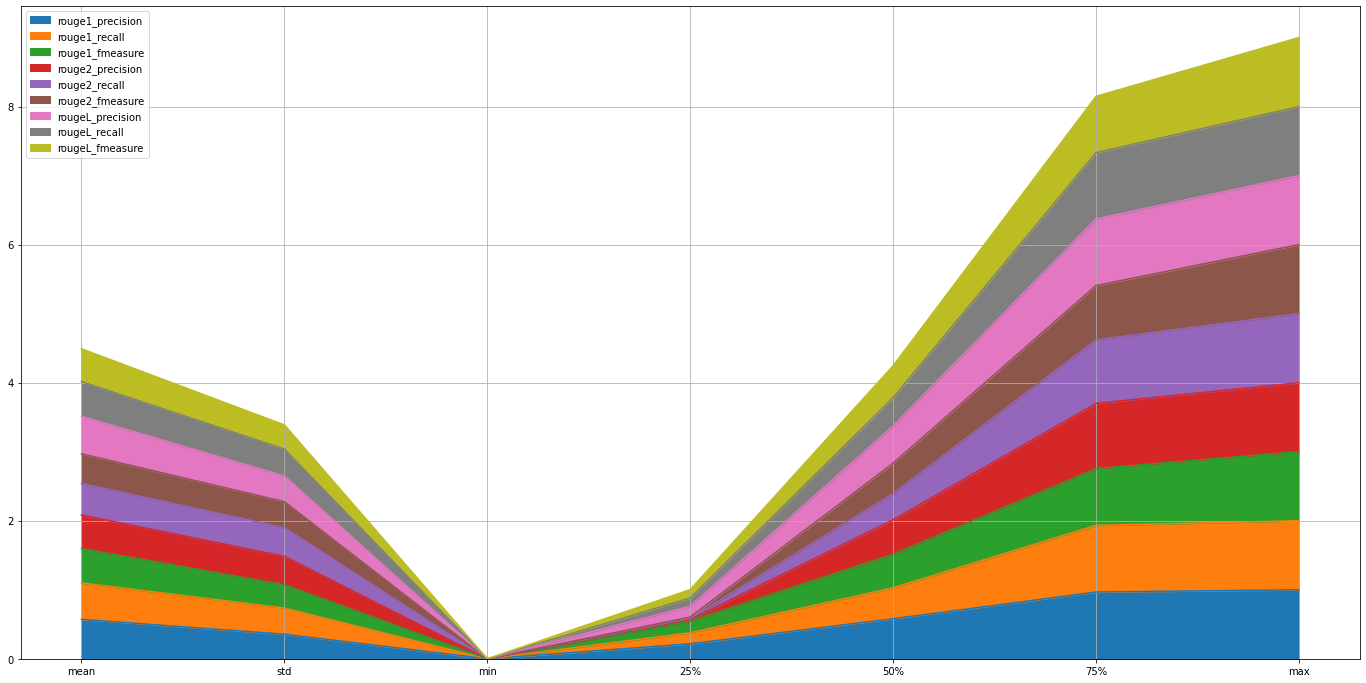

In [77]:
kind="area"
scores_to_plot.plot(kind=kind,figsize=(24,12), grid=True, rot=0)
plt.savefig(os.path.join(data_dir,f"score_stats_{data_type}_{kind}.png"),dpi=300)
FileLinks(".")

In [52]:
FileLinks(".")

./
  __notebook_source__.ipynb
./Data/
  score_stats_test_2.png
  score_stats_test.png
  SGD_model.pkl
  summaResults_test.txt

___
___
# **Notes**


1. scoring -> label rougeL -> sentence feats -> train
2. grid search ?! (or manual fine tuning)
3. test -> input doc -> predict score -> keep N first sentences or keep those over a threshold -> create summary -> calculate rouge1/2/L

___
### **References**

1. [Named Entity Recognition (NER) with TensorflowNamed Entity Recognition (NER) with Tensorflow](https://www.kaggle.com/code/naseralqaydeh/named-entity-recognition-ner-with-tensorflow)
2. [Extractive Summarization using Deep LearningExtractive Summarization using Deep Learning](https://arxiv.org/pdf/1708.04439v1.pdf)
3. [NLTK](https://www.bogotobogo.com/python/NLTK/Stemming_NLTK.php)
4. [Text Features Library](https://github.com/pmbaumgartner/text-feat-lib/tree/master/notebooks)
5. []()



### **Feats**
1. [Feature extraction](https://arxiv.org/pdf/1708.04439v1.pdf)
    1. Number of thematic words
    2. Sentence position
    3. Sentence length
    4. Sentence position relative to paragraph
    5. Number of proper nouns
    6. Number of numerals
    7. Number of named entities
    8. Term Frequency-Inverse Sentence Frequency
    9. Sentence to Centroid similarity
    
    
2. [Text Summarization References](https://github.com/Tian312/awesome-text-summarization/blob/master/README.md)



___
### **Feature Base**

The feature base model extracts the features of the sentence, then evaluate its importance. Here is the representative research.
Sentence Extraction Based Single Document Summarization
Following features are used in the above method.

1. Position of the sentence in the input document
2. Presence of the verb in the sentence
3. Length of the sentence
4. Term frequency
5. Named entity tag NE
6. Font style

…etc. All the features are accumulated as the score.
The No.of coreferences are the number of pronouns to the previous sentence. It is simply calculated by counting the pronouns occurred in the first half of the sentence. So the Score represents the reference to the previous sentence.
Now we can evaluate each sentence. Next is selecting the sentence to avoid the duplicate of the information. In this paper, the same word between the new and selected sentence is considered. And the refinement to connect the selected sentences are executed.
Luhn’s Algorithm is also feature base. It evaluates the “significance” of the word that is calculated from the frequency.
You can try feature base text summarization by TextTeaser (PyTeaser is available for Python user).

# Unused

In [ ]:
# train_set = f"..{os.sep}Data{os.sep}release{os.sep}train.jsonl"
# dev_set = f"..{os.sep}Data{os.sep}release{os.sep}dev.jsonl"
# test_set = f"..{os.sep}Data{os.sep}release{os.sep}test.jsonl"
# load json files and convert them to dataframes to load faster next time
# train_df = funs.json_to_df(train_set,"train")
# dev_df = funs.json_to_df(dev_set,"dev")
# test_df = funs.json_to_df(test_set,"test")



In [ ]:
# colab command to download the dataset
# !kaggle datasets download -d tkylafi/summarizer-data

In [27]:
# for items in os.walk("/kaggle/input"):
#     print(items)
    

# test_json=json.loads(test_json_path)

,index,url,archive,title,date,text,summary,compression,coverage,density,compression_bin,coverage_bin,density_bin
0,1,http://www.nytimes.com/2006/06/05/technology/0...,http://web.archive.org/web/20060620021852id_/h...,India Becoming a Crucial Cog in the Machine at...,20060620021852,"BANGALORE, India, June 4  The world's biggest...",India provides I.B.M. with its fastest-growing...,56.045455,0.954545,16.500000,high,high,extractive
1,2,http://www.nydailynews.com/archives/news/1995/...,http://web.archive.org/web/20110210093603id_/h...,NEW YORKERS' ONLY REGRET WAS STAYING HOME,20110210093603,"This story was reported by: NICK CHARLES, AUST...",As many black men marched on Washington yester...,6.152941,0.976471,24.600000,low,high,extractive
2,4,http://www.reuters.com/article/2011/01/31/us-i...,http://web.archive.org/web/20120321005702id_/h...,Freed American hiker summoned back by Iran court,20120321005702,"TEHRAN | Mon Jan 31, 2011 9:17am EST\n\nTEHRAN...",TEHRAN (Reuters) - An American woman who was f...,7.902439,1.000000,39.048780,low,high,extractive
3,5,http://www.reuters.com/article/2007/08/17/us-c...,http://web.archive.org/web/20120606165550id_/h...,"Breast cancer vaccine looks safe, study shows",20120606165550,"By Maggie Fox, Health and Science Editor\n\nWA...",WASHINGTON (Reuters) - A vaccine designed to t...,17.162162,1.000000,35.054054,medium,high,extractive
4,10,http://www.bostonglobe.com/arts/music/2014/01/...,http://web.archive.org/web/20140131020936id_/h...,Music review: Jake Bugg at the House of Blues,20140131020936,As the lights went down at the nearly sold-out...,As the lights went down at the nearly sold-out...,2.153061,0.994898,55.658163,low,high,extractive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36367,108828,http://www.washingtonpost.com/wp-dyn/content/a...,https://web.archive.org/web/2005060119id_/http...,Prisoners' Religious Rights Law Upheld,2005060119,The Supreme Court upheld a federal religious f...,The Supreme Court upheld a federal religious f...,13.605263,1.000000,38.000000,low,high,extractive
36368,108829,http://www.washingtonpost.com/wp-dyn/content/d...,https://web.archive.org/web/2005060119id_/http...,Arthur Andersen Case,2005060119,The Supreme Court's unanimous rebuff of the 20...,The Supreme Court's unanimous rebuff of the 20...,62.765957,1.000000,47.000000,high,high,extractive
36369,108831,http://www.washingtonpost.com/wp-dyn/content/a...,https://web.archive.org/web/2005052419id_/http...,Corcoran Director Quits; Trustees Shelve Gehry...,2005052419,David C. Levy resigned yesterday as president ...,David C. Levy resigned yesterday as president ...,15.000000,1.000000,48.000000,low,high,extractive
36370,108834,http://www.washingtonpost.com/wp-dyn/content/a...,https://web.archive.org/web/2005052019id_/http...,"In L.A., a Pol for a Polyglot City",2005052019,LOS ANGELES -- The politics of the great Ameri...,LOS ANGELES -- The politics of the great Ameri...,17.905660,1.000000,53.000000,medium,high,extractive
